Preparing Data And Preprocessing

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import LocalOutlierFactor
from kneed import KneeLocator

# ---- STEP 1: LOAD DATA ----
# Load the dataset (Replace with actual data path)
df = pd.read_excel('./data_files/Data_re.xlsx')  # Ensure the file exists

# ---- STEP 2: FEATURE SELECTION ----
# Remove non-informative columns
cols_to_drop = ['object_id', 'specz_name', 'coord']  # Adjust based on your dataset
features = [col for col in df.columns if col not in cols_to_drop + ['specz_redshift']]
df_selected = df[features]

# Remove low-variance features
var_thresh = VarianceThreshold(threshold=0.01)
df_selected = pd.DataFrame(var_thresh.fit_transform(df_selected), 
                           columns=np.array(features)[var_thresh.get_support()])

# ---- STEP 3: REMOVE OUTLIERS ----
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
outliers = lof.fit_predict(df_selected)
df_clean = df_selected[outliers == 1].copy()  # Keep only non-outliers
df_clean.loc[:, 'specz_redshift'] = df.loc[outliers == 1, 'specz_redshift'].values

# ---- STEP 4: SCALING & TRANSFORMING ----
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean.drop(columns=['specz_redshift']))

# Apply Power Transformation (Yeo-Johnson for normalizing skewed data)
power_transformer = PowerTransformer(method='yeo-johnson')
df_transformed = power_transformer.fit_transform(df_scaled)

# ---- STEP 5: DIMENSIONALITY REDUCTION WITH t-SNE ----
from sklearn.manifold import TSNE
X_pca = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(df_transformed)  # Using t-SNE for better clustering
X_pca = pca.fit_transform(df_transformed)


Clustering (DBScan, K means and Gaussian Mixture Method)

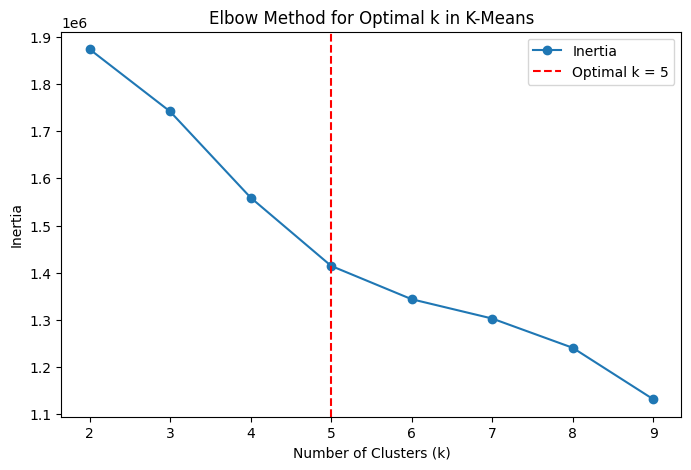

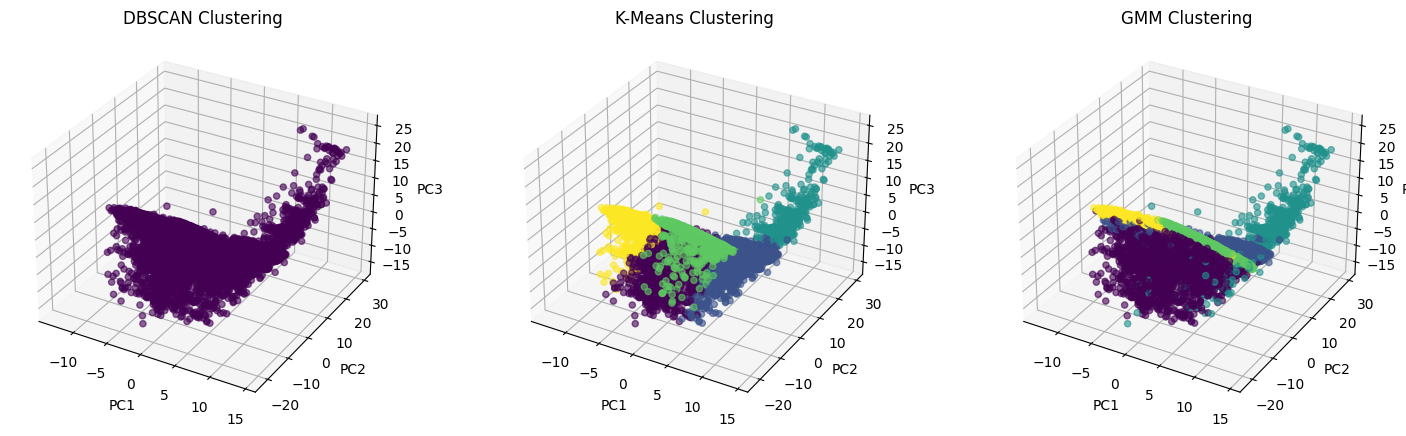

First 10 sorted K-Distance values: [0.56736195 0.59150945 0.6003372  0.60257184 0.62606495 0.62616797
 0.63788856 0.654982   0.654982   0.67076804]


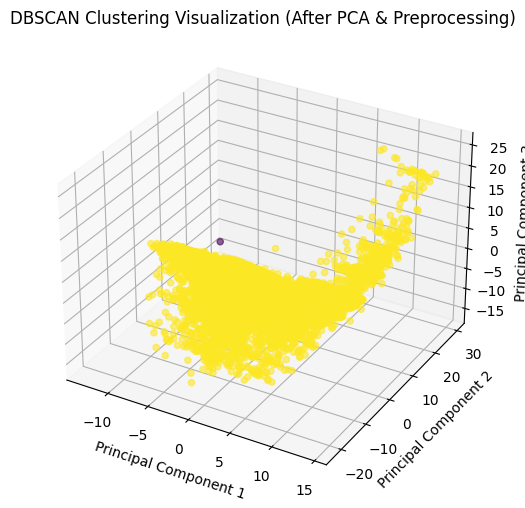

In [37]:
# ---- STEP 6: APPLY DBSCAN CLUSTERING ----
dbscan = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
cluster_labels_dbscan = dbscan.fit_predict(X_pca)
df_clean.loc[:, 'cluster_dbscan'] = cluster_labels_dbscan

# ---- STEP 6B: APPLY K-MEANS & GMM ----
# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Find the optimal k using the "knee" method
knee_locator = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

# Plot the Elbow Curve with optimal k annotation
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', label='Inertia')
plt.axvline(x=optimal_k, linestyle='--', color='red', label=f'Optimal k = {optimal_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k in K-Means')
plt.legend()
plt.show()

# Apply K-Means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_clean.loc[:, 'cluster_kmeans'] = kmeans.fit_predict(X_pca)

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df_clean.loc[:, 'cluster_gmm'] = gmm.fit_predict(X_pca)

# ---- STEP 7: VISUALIZE COMPARISON OF CLUSTERING METHODS (3D PLOTS) ----
fig = plt.figure(figsize=(18, 5))

# DBSCAN 3D Plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels_dbscan, cmap='viridis', alpha=0.6)
ax1.set_title("DBSCAN Clustering")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")

# K-Means 3D Plot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=df_clean['cluster_kmeans'], cmap='viridis', alpha=0.6)
ax2.set_title("K-Means Clustering")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

# GMM 3D Plot
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=df_clean['cluster_gmm'], cmap='viridis', alpha=0.6)
ax3.set_title("GMM Clustering")
ax3.set_xlabel("PC1")
ax3.set_ylabel("PC2")
ax3.set_zlabel("PC3")

plt.show()

# Print first few K-Distance values to manually determine best eps
print("First 10 sorted K-Distance values:", distances[:10])

# Tune DBSCAN parameters
dbscan = DBSCAN(eps=0.3, min_samples=6, metric='cosine')
cluster_labels = dbscan.fit_predict(X_pca)
df_clean.loc[:, 'cluster'] = cluster_labels

# ---- STEP 7: VISUALIZE DBSCAN CLUSTERS IN 3D ----
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', alpha=0.6)
ax.set_title("DBSCAN Clustering Visualization (After PCA & Preprocessing)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()


Random Forest

Random Forest Regression Results:
CLUSTER_DBSCAN - MSE: 0.056978, R2: 0.824438
CLUSTER_KMEANS - MSE: 0.056997, R2: 0.824379
CLUSTER_GMM - MSE: 0.057061, R2: 0.824181


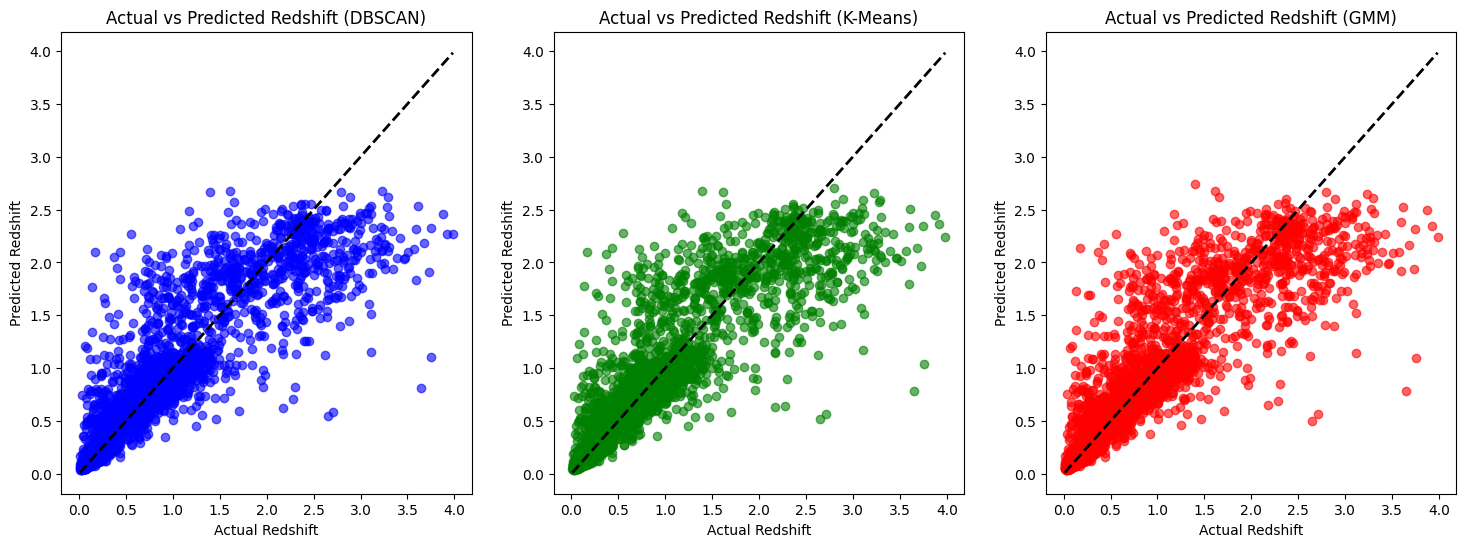

Random Forest Regression Results:
DBSCAN - MSE: 0.056978002681944064, R2: 0.8244381822740374
K-Means - MSE: 0.05699705422978975, R2: 0.8243794802449588
GMM - MSE: 0.05706136583490366, R2: 0.8241813219775007
Random Forest Regression Results:
Mean Squared Error: 0.05680204809029125
R2 Score: 0.8249803372547979


In [38]:
# ---- STEP 8: RANDOM FOREST REGRESSION ----
# Train separate Random Forest models for each clustering method

results = {}

for cluster_type in ['cluster_dbscan', 'cluster_kmeans', 'cluster_gmm']:
    df_temp = pd.get_dummies(df_clean, columns=[cluster_type], prefix=[f'clust_{cluster_type}'])
    X = df_temp.drop(columns=['specz_redshift'])
    y = df_temp['specz_redshift']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[cluster_type] = {'MSE': mse, 'R2': r2, 'y_pred': y_pred}

# ---- STEP 10: COMPARE RESULTS ACROSS CLUSTERING METHODS ----
mse_dbscan, r2_dbscan = results['cluster_dbscan']['MSE'], results['cluster_dbscan']['R2']
mse_kmeans, r2_kmeans = results['cluster_kmeans']['MSE'], results['cluster_kmeans']['R2']
mse_gmm, r2_gmm = results['cluster_gmm']['MSE'], results['cluster_gmm']['R2']

print("Random Forest Regression Results:")
for cluster_type, metrics in results.items():
    print(f"{cluster_type.upper()} - MSE: {metrics['MSE']:.6f}, R2: {metrics['R2']:.6f}")
df_encoded = pd.get_dummies(df_clean, columns=['cluster_dbscan', 'cluster_kmeans', 'cluster_gmm'], prefix=['clust_dbscan', 'clust_kmeans', 'clust_gmm'])

# Define target and features
X = df_encoded.drop(columns=['specz_redshift'])
y = df_encoded['specz_redshift']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# ---- STEP 9: VISUALIZE REGRESSION RESULTS ----
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# DBSCAN
ax[0].scatter(y_test, results['cluster_dbscan']['y_pred'], alpha=0.6, color='blue')
ax[0].set_xlabel('Actual Redshift')
ax[0].set_ylabel('Predicted Redshift')
ax[0].set_title('Actual vs Predicted Redshift (DBSCAN)')
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# K-Means
ax[1].scatter(y_test, results['cluster_kmeans']['y_pred'], alpha=0.6, color='green')
ax[1].set_xlabel('Actual Redshift')
ax[1].set_ylabel('Predicted Redshift')
ax[1].set_title('Actual vs Predicted Redshift (K-Means)')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# GMM
ax[2].scatter(y_test, results['cluster_gmm']['y_pred'], alpha=0.6, color='red')
ax[2].set_xlabel('Actual Redshift')
ax[2].set_ylabel('Predicted Redshift')
ax[2].set_title('Actual vs Predicted Redshift (GMM)')
ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# ---- STEP 10: COMPARE RESULTS ACROSS CLUSTERING METHODS ----
print("Random Forest Regression Results:")
print(f"DBSCAN - MSE: {mse_dbscan}, R2: {r2_dbscan}")
print(f"K-Means - MSE: {mse_kmeans}, R2: {r2_kmeans}")
print(f"GMM - MSE: {mse_gmm}, R2: {r2_gmm}")
print(f"Random Forest Regression Results:\nMean Squared Error: {mse}\nR2 Score: {r2}")
